# **dVRK Instrument Segmentation**
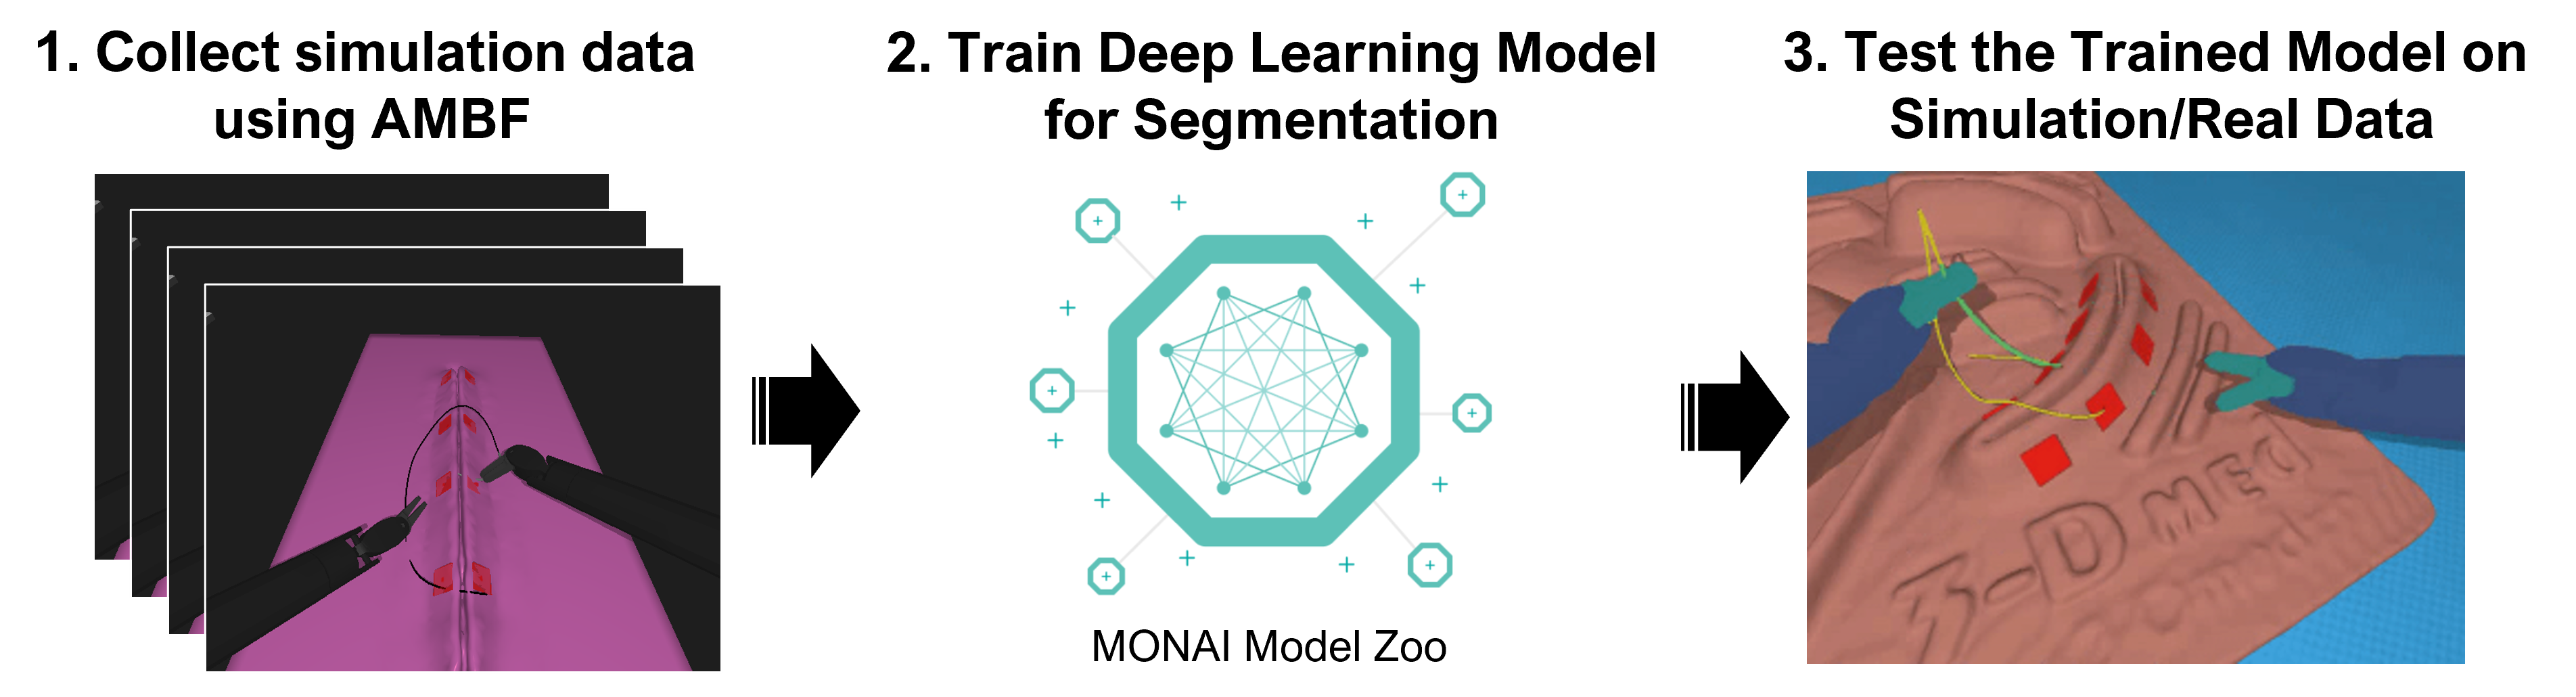
---



Congratulations on successfully collecting the data using AMBF!<br> Now, you've collected the simulation data, we will walk you through the process of training and testing a segmentation model. Even if you haven't collected the data on your own, do not worry; we will provide the data for you.

---




# **Setup**



## 1. Check if you are using GPU
---
The following code should output '/device:GPU:0'. 
If not, go to 'Edit > Notebook settings' and set 'Hardware Accelerator' as 'GPU'.


In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# 2. Import the Data to Colab Session.
---
First, mount your google drive. You would need to grant an access to your google drive data.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Second, copy the data from Drive to Colab Session. In this workshop, We will only use one data folder for training and one folder for validation.

In [3]:
!mkdir /content/data
!cp -r /content/drive/Shareddrives/ISMR_workshop/ISMR23/AmbfSegmentationDataset/rec01 /content/data/rec01

In [4]:
!cp -r /content/drive/Shareddrives/ISMR_workshop/ISMR23/AmbfSegmentationDataset/rec02 /content/data/rec02

# 3. Install MONAI

In [5]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.9 MB/s eta 0:00:00


# 4. Import the required libraries
---
First, change the working directory to the current folder (ISMR23 Workshop)

In [6]:
#%cd 'drive/Shareddrives/ISMR_workshop/ISMR23'
!git clone https://github.com/Accelnet-project-repositories/dVRK-segmentation-models.git
%cd /content/dVRK-segmentation-models


/content/drive/MyDrive/Colab Notebooks/ISMR23


**Then, import libaries**

In [7]:
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import numpy as np

import monai
from monai.data import ThreadDataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import FlexibleUNet
import monai.transforms as mt
from monai.visualize.utils import blend_images

from dataclasses import dataclass, field
import pickle
from surg_seg.Trainers.Trainer import ModelTrainer
from surg_seg.Datasets.ImageDataset import ImageSegmentationDataset, ImageTransforms, display_untransformed_images
from surg_seg.Datasets.ImageDataset import display_transformed_image
# from ImageDataset import ImageSegmentationDataset, ImageTransforms, display_untransformed_images
# from segmentation_model import  ModelTrainer

# **Load the Data**

In [9]:
root = Path("/content/data")
# train_dirs = [root / "rec01", root / "rec03", root / "rec05"]
# val_dirs = [root / "rec02", root / "rec04"]
## Here, we only use one folder for training and validation to reduce the training time. ##
train_dirs = [root / "rec01"]
val_dirs = [root / "rec02"]
ds = ImageSegmentationDataset(train_dirs, "5colors")
dl = ThreadDataLoader(ds, batch_size=4, num_workers=0, shuffle=True)

val_ds = ImageSegmentationDataset(val_dirs, "5colors")
val_dl = ThreadDataLoader(val_ds, batch_size=4, num_workers=0, shuffle=True)

print(f"Training dataset size: {len(ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Training dataset size: 149
Validation dataset size: 149


Display the data

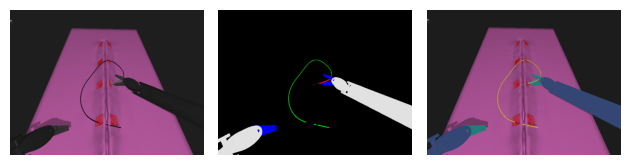

In [ ]:
display_untransformed_images(100, ds)
display_untransformed_images(50, ds)
display_transformed_images(20, ds)

# **Load pretrained model**

In [ ]:
def create_FlexibleUnet(device, pretrained_weights_path: Path, out_channels: int):

    model = FlexibleUNet(
        in_channels=3,
        out_channels=out_channels,
        backbone="efficientnet-b0",
        pretrained=True,
        is_pad=False,
    ).to(device)

    pretrained_weights = monai.bundle.load(
        name="endoscopic_tool_segmentation", bundle_dir=pretrained_weights_path, version="0.2.0"
    )
    model_weight = model.state_dict()
    weights_no_head = {k: v for k, v in pretrained_weights.items() if not "segmentation_head" in k}
    model_weight.update(weights_no_head)
    model.load_state_dict(model_weight)

    return model



# **Train the Model**

Loss: 0.0697: 100%|██████████| 2/2 [01:04<00:00, 32.22s/it]


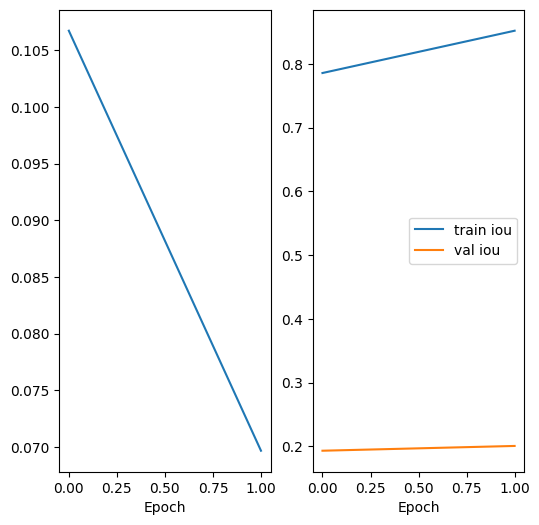

Last train IOU 0.851996123790741
Last validation IOU 0.2005484253168106


In [12]:
path_to_shared_assets = Path("/content/drive/Shareddrives/ISMR_workshop/ISMR23")
device = "cuda"
pretrained_weights_path = Path("/content/weights/pretrained_weights")
model = create_FlexibleUnet(device, pretrained_weights_path, ds.label_channels)
# I lowered the learning rate from 1e-2 to 1e-3 for stability. This also means the model needs more epochs for training.
optimizer = torch.optim.Adam(model.parameters(), 1e-3) 

## Loading Checkpoints ##
# checkpoint_path = path_to_shared_assets / "weights/myweights_image/checkpoints.pt" 
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

EPOCH = 2
trainer = ModelTrainer(device=device, max_epochs=EPOCH)
model, training_stats = trainer.train_model(model, optimizer, dl, validation_dl=val_dl)

model_dir = Path("/content/weights")
model_dir.mkdir(exist_ok=True)
model_path = model_dir / "myweights.pt"
torch.save(model.state_dict(), model_path)
## Saving Checkpoints ##
# torch.save({
#     'epoch': EPOCH,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': trainer.loss_function}, model_path / "myweights.pt")

training_stats.to_pickle(model_dir)
training_stats.plot_stats(file_path=model_dir)

print(f"Last train IOU {training_stats.iou_list[-1]}")
print(f"Last validation IOU {training_stats.validation_iou_list[-1]}")

# **Inference on Unseen Data (Simulation)**

# **Inference on Real Data**

# TODO before workshop Irene.

0. Test the new jupyter notebook. I did some small changes to use the code from the repo.
1. Add documentation on how to copy the jupyter notebook from github. 
2. Add a section explaining that you can upload your own data to google drive and then copied it to colab. Ask the user to complete the path to where the date is saved in their google drive. Also, explain that if you were not able to collected your data you can use the data we provide.
3. **optional** Script to copy back weights to google drive. Download from the colab gui is extremely slow. We want to copy back the new weights you get after training the network in Colab.
4. Complete inference blocks. See example scripts in main repo. Probably show three columns -> raw_image, raw_image+labels, raw_image+prediction. Show multiple images. Another idea could be to have one colum witht he predictions of the model they just trained and the predictions of the good model we provide.See https://github.com/Accelnet-project-repositories/dVRK-segmentation-models/blob/main/scripts/show_im_and_inference.py
   
5. Upload new assets data, real_data to google drive. Another options is adding the data to kaggle dataset and downloading via kaggle api. Use whatever seems to be best. See https://github.com/jabarragann/ComplianceProject/tree/icra-2023#user-content-data-download.  Another options is uploading everything to a repository in github if its possible. For this option create a new repo in https://github.com/Accelnet-project-repositories
and push all the data there.

6. **Optional** Showing inference videos on colab.

I have a script to create inference mp4 videos which only requires and input .avi video and the weights
https://github.com/Accelnet-project-repositories/dVRK-segmentation-models/blob/main/scripts/create_inference_video.py

Also, I saw it is possible to play .mp4 videos directly on colab. https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab

Might be nice to create the inference video and then show it directly on colab.

**For all the changes you can fork this repo and then do a pull request**

7. checkpoint of model trained for 40 epochs (trained on colab)
   
Sample output of inference script:

![sample_images](./images/sample_inference_plots.png)






# TODO Juan 

1. Disable right camera in SRC repo for better performance.
2. Add instructions of who to use scripts
3. Test scripts in ros python interpreter in case somebody wants to avoid the Anaconda installation.
4. Train a better model including data without the instrument arms and differen camera angles.
5. Add software to Adnan's laptop and test.